In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
X, labels = make_moons(n_samples=10000, noise=0.2, random_state=42)
X = X[labels==0]

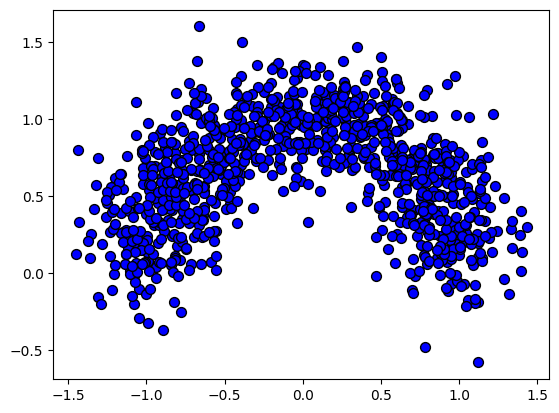

In [3]:
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50)
plt.show()

In [4]:
data = torch.tensor(X, dtype=torch.float32).to(device)

In [49]:
class Denoiser(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Denoiser, self).__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, t):
        t = torch.unsqueeze(t, 1)
        x_for = torch.cat((x, t), dim=1)
        x_for = torch.relu(self.fc1(x_for))
        x_for = torch.relu(self.fc2(x_for))
        x_for = torch.relu(self.fc3(x_for))
        #x_for = torch.relu(self.fc4(x_for))
        return self.fc5(x_for)

model = Denoiser(2, 2, 64).to(device)

In [53]:
class DDPM:
    def __init__(self, model, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.model = model
        self.timesteps = timesteps
        self.reversed_time_steps = np.arange(self.timesteps)[::-1]
        self.betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def sample(self, num_samples):
        with torch.no_grad():  # avoid backprop wrt model parameters
            x = torch.randn((num_samples, 2), dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                eps = self.model(x, t_tensor)

                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]

                mean = 1/(torch.sqrt(alpha_t))*(x-(beta_t/torch.sqrt(1-alpha_t_cumprod))*eps)

                noise = torch.randn_like(x)
                x = mean + torch.sqrt(beta_t) * noise
        return x

    def train(self, data, epochs=1000, batch_size=64, lr=1e-3):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        
        losses = []

        for epoch in range(epochs):
            mean_loss = 0
            i = 0
            for batch in dataloader:
                optimizer.zero_grad()
                t = torch.randint(0, self.timesteps, (batch.size(0),), device=batch.device).long()
                noise = torch.randn_like(batch, dtype=torch.float32)
                noisy_data = torch.sqrt(self.alphas_cumprod[t]).view(-1, 1) * batch + torch.sqrt(1.0 - self.alphas_cumprod[t]).view(-1, 1) * noise
                predicted_noise = self.model(noisy_data, t)
                loss = criterion(predicted_noise, noise)
                mean_loss+=loss.item()
                i+=1
                loss.backward()
                optimizer.step()

            if epoch % 100 == 0:
                losses.append(mean_loss/i)
                print(f'Epoch {epoch}, Loss: {mean_loss/i}')
        return losses
    
ddpm = DDPM(model, timesteps=5000)

In [54]:
losses = ddpm.train(data, epochs=10000, batch_size=64, lr=1e-4)

Epoch 0, Loss: 2.312480453401804
Epoch 100, Loss: 0.5506143309175968
Epoch 200, Loss: 0.31950866896659136
Epoch 300, Loss: 0.1599393282085657
Epoch 400, Loss: 0.0984284698497504
Epoch 500, Loss: 0.08554485579952598
Epoch 600, Loss: 0.20541052869521081
Epoch 700, Loss: 0.12218598695471883
Epoch 800, Loss: 0.093042021850124
Epoch 900, Loss: 0.08534685638733208
Epoch 1000, Loss: 0.1165676792152226
Epoch 1100, Loss: 0.07773079944308847
Epoch 1200, Loss: 0.08649478387087584
Epoch 1300, Loss: 0.20692740939557552
Epoch 1400, Loss: 0.11559550673700869
Epoch 1500, Loss: 0.1692132791504264
Epoch 1600, Loss: 0.10325866658240557
Epoch 1700, Loss: 0.08987947273999453
Epoch 1800, Loss: 0.09964638785459101
Epoch 1900, Loss: 0.09409315697848797
Epoch 2000, Loss: 0.1483599953353405
Epoch 2100, Loss: 0.09492774540558457
Epoch 2200, Loss: 0.08284840208943933
Epoch 2300, Loss: 0.14818097045645118
Epoch 2400, Loss: 0.09574858366977423
Epoch 2500, Loss: 0.08595898584462702
Epoch 2600, Loss: 0.06547761976253

KeyboardInterrupt: 

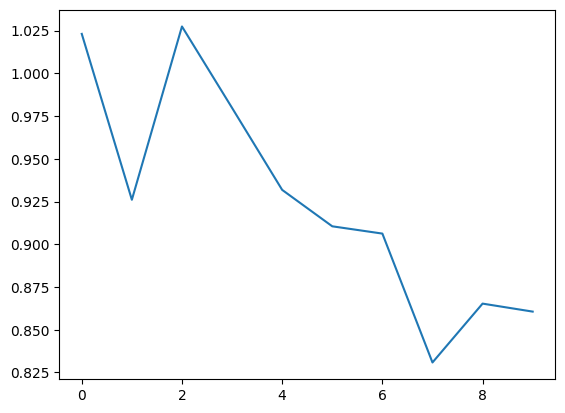

In [55]:
plt.plot(losses)
plt.show()

In [56]:
new_samples = ddpm.sample(num_samples=500).cpu().detach().numpy()

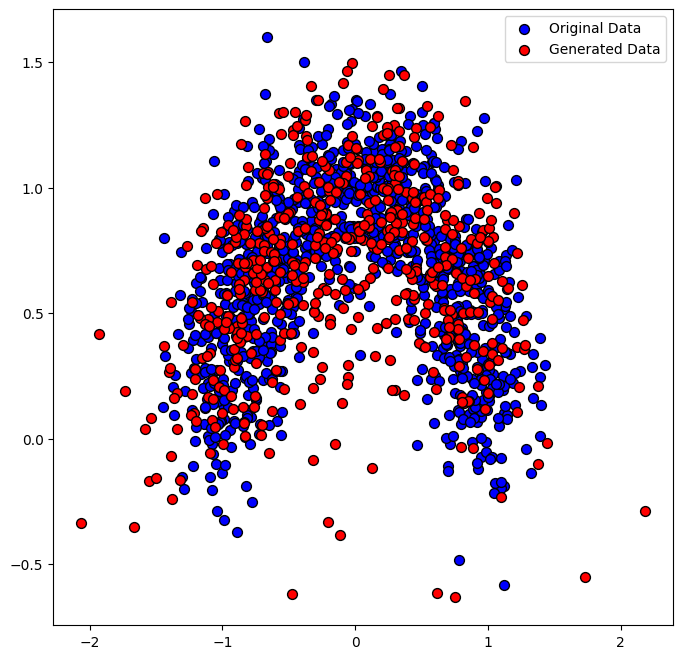

In [57]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50, label='Original Data')
plt.scatter(new_samples[:, 0], new_samples[:, 1], c='red', marker='o', edgecolor='k', s=50, label='Generated Data')
plt.legend()
plt.show()